<a href="https://colab.research.google.com/github/hridaykondru/ML-model-for-Multiple-Healthcare-Domains/blob/main/ML_model_for_Multiple_Healthcare_Domains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common imports

In [1]:
!pip install tensorflow
!pip install kaggle

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [3]:
import tensorflow as tf

# Check if a GPU is available
if tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None):
    print("GPU is available")
else:
    print("No GPU is available")

# Check which GPU is currently being used
print("GPU devices:", tf.config.experimental.list_physical_devices('GPU'))


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Creating the model

In [4]:
# Load the pre-trained VGG-16 model (without the top classification layers)
img_size=150
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)))

# Freeze the convolutional layers (optional)
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
# Add new classification layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)  # High patience to make it less strict

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=1, min_lr=0.000001)
# High patience and low factor to make it less strict

callbacks_list = [early, learning_rate_reduction]


# Chest X-ray classification for Pneumonia

Importing Dataset

In [ ]:
!mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Semester 7/BTP_new/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:36<00:00, 93.4MB/s]
100% 2.29G/2.29G [00:36<00:00, 67.3MB/s]


In [ ]:
!ls

brain_tumor_dataset  chest-xray-pneumonia.zip  drive  no  sample_data  yes


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
!rm chest-xray-pneumonia.zip
!ls

brain_tumor_dataset  chest_xray  drive	no  sample_data  yes


In [ ]:
base_dir="/content/chest_xray/chest_xray/"
train_pneumonia_dir=base_dir+"train/PNEUMONIA/"
train_normal_dir=base_dir+"train/NORMAL/"
test_normal_dir=base_dir+"test/NORMAL/"
test_pneumonia_dir=base_dir+"test/PNEUMONIA/"
val_pnrumonia_dir=base_dir+"val/PNEUMONIA/"
val_normal_dir=base_dir+"val/NORMAL/"
train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

In [ ]:
def get_imgs(path_arr,pneumonia,img_size=150):
  x=[]
  y=[]
  for img_loc in path_arr:
    try:
      img_arr = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
      img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
      resized_arr = cv2.resize(img_arr_rgb, (img_size, img_size)) # Reshaping images to preferred size
      x.append(resized_arr)
      y.append(pneumonia)
    except Exception as e:
      continue
  return((x,y))

In [ ]:
x_train_pn,y_train_pn=get_imgs(train_pn,1,img_size)
x_train_normal,y_train_normal=get_imgs(train_normal,0,img_size)
x_test_pn,y_test_pn=get_imgs(test_pn,1,img_size)
x_test_normal,y_test_normal=get_imgs(test_normal,0,img_size)
x_val_pn,y_val_pn=get_imgs(val_pn,1,img_size)
x_val_normal,y_val_normal=get_imgs(val_normal,0,img_size)
x_train=x_train_pn+x_train_normal
y_train=y_train_pn+y_train_normal
x_test=x_test_pn+x_test_normal
y_test=y_test_pn+y_test_normal
x_val=x_val_pn+x_val_normal
y_val=y_val_pn+y_val_normal

Pre-processing the data

In [ ]:
#Normalize the data
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_val=np.array(x_val)/255

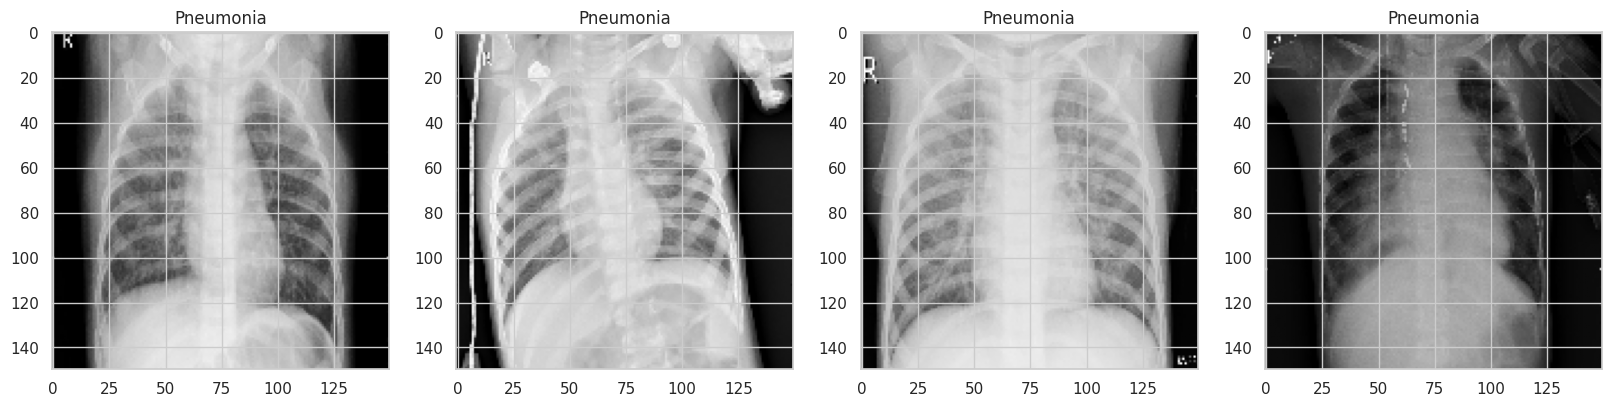

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('Pneumonia')
    plt.imshow(x_train_pn[i]/255)
    k=k+1;

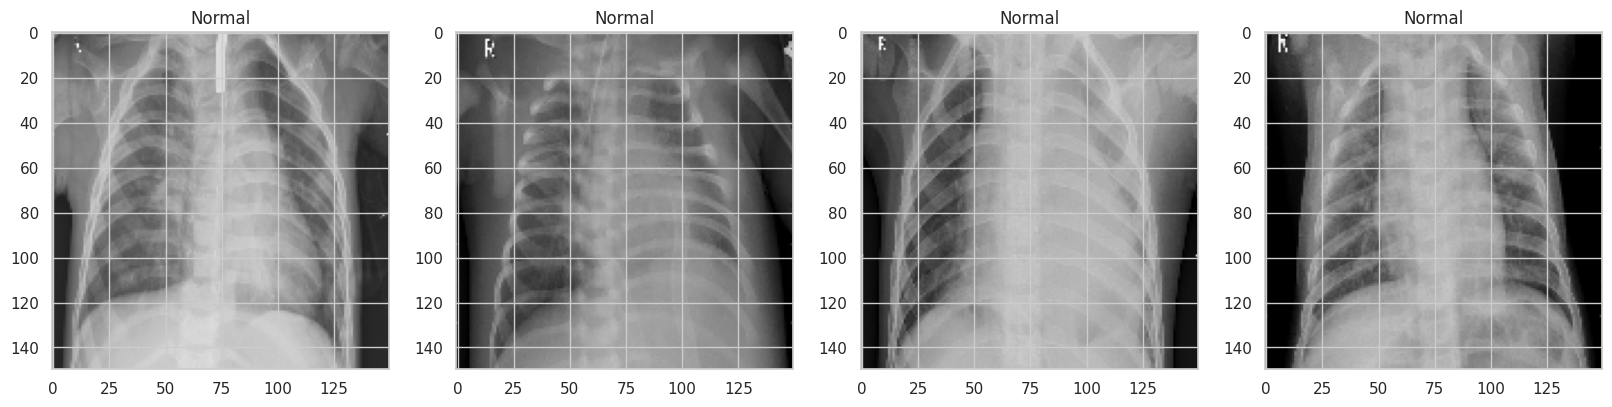

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('Normal')
    plt.imshow(x_test_pn[i]/255)
    k=k+1;

The purpose of reshaping the image data into a 4D tensor is to ensure that the input data has the correct shape for deep learning models to process. In particular, the 4D tensor has dimensions `(number of images, img_size, img_size, 3)`, where `number of images` is the number of images in the dataset, `img_size` is the size of the images after resizing, and `3` represents the number of color channels (1 for grayscale images, 3 for RGB images).

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

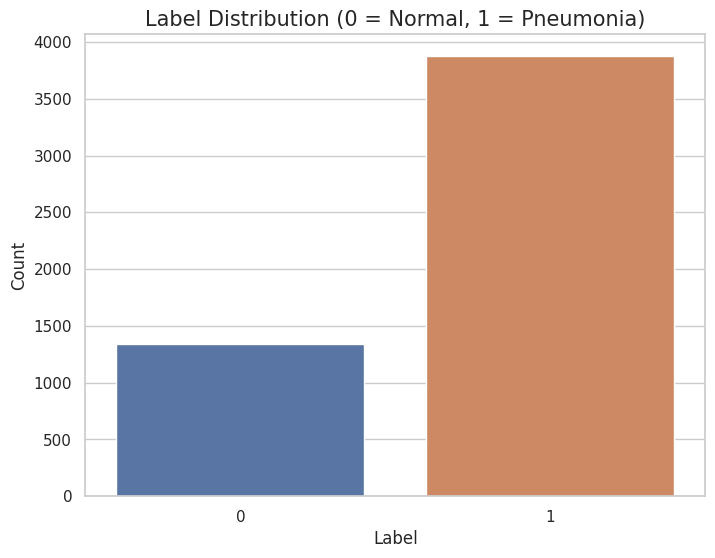

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Label Distribution (0 = Normal, 1 = Pneumonia)", fontsize=15)
plt.show()

Data is imbalanced, hence we need to perform data augmentation. Here, we will:
* Randomly rotate some training images by 30 degrees
* Randomly Zoom by 20% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* Randomly flip images horizontally.

Training the model on Chest X-ray to predict Pneumonia

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
# Binary classification (1 or 0)
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

Epoch 1/100
163/163 [==============================] - 36s 212ms/step - loss: 0.2364 - accuracy: 0.8999 - val_loss: 0.2815 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 34s 211ms/step - loss: 0.1716 - accuracy: 0.9302 - val_loss: 0.5172 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 35s 213ms/step - loss: 0.1500 - accuracy: 0.9381 - val_loss: 0.2347 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 34s 210ms/step - loss: 0.1437 - accuracy: 0.9463 - val_loss: 0.5238 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 35s 212ms/step - loss: 0.1449 - accuracy: 0.9425 - val_loss: 0.4419 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 34s 211ms/step - loss: 0.1249 - accuracy: 0.9536 - val_loss: 0.3755 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/100
163/163 [=========================

<Axes: >

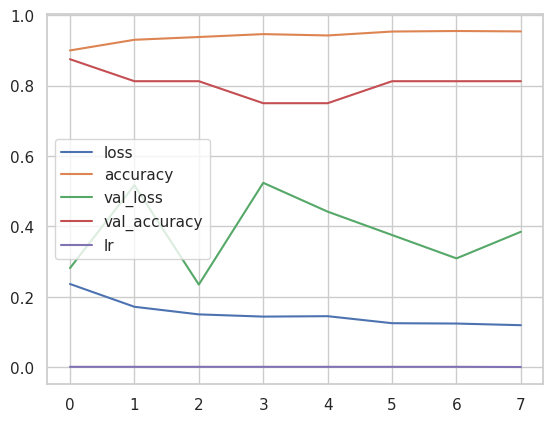

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

20/20 [==============================] - 2s 70ms/step - loss: 0.2529 - accuracy: 0.9183
Test Loss: 0.2528747618198395
Test Accuracy: 0.9182692170143127


Benchmark [Kaggle Notebook](https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy?kernelSessionId=37993062):

Loss -  0.2935715940518257
Accuracy -  0.9262820482254028

# Endoscopy image classification

Importing Dataset

In [ ]:
!mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Semester 7/BTP_new/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d meetnagadia/kvasir-dataset

100% 1.15G/1.15G [00:35<00:00, 38.2MB/s]
100% 1.15G/1.15G [00:35<00:00, 35.1MB/s]


In [ ]:
!ls

drive  kvasir-dataset.zip  sample_data


In [ ]:
!unzip kvasir-dataset.zip

Archive:  kvasir-dataset.zip
  inflating: kvasir-dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/007d5aa7-7289-4bad-aa4a-5c3a259e9b19.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/01507fbd-4d38-4525-9768-7754710f507c.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/018ed8ed-e489-4bbb-8a99-3346db9ec160.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/0195c5a6-5ddf-471c-9868-2ea66b81f440.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/01d38b8f-74b2-4147-9519-448d05bf8745.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/02c10865-9d23-4f6b-aa5d-f73b63b6d67f.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/031a6e89-d3b7-48c8-8e2f-db991030f959.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/03a49a2e-c8d4-4dcd-b5e7-3d1722ed5db3.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/041daea7-c9cd-43f9-ae77-

In [ ]:
!rm kvasir-dataset.zip
!ls

drive  kvasir-dataset  sample_data


In [ ]:
base_dir="/content/kvasir-dataset/"
d_l_p_dir=base_dir+"dyed-lifted-polyps/"
d_r_m_dir=base_dir+"dyed-resection-margins/"
e_dir=base_dir+"esophagitis/"
n_c_dir=base_dir+"normal-cecum/"
n_p_dir=base_dir+"normal-pylorus/"
n_z_dir=base_dir+"normal-z-line/"
p_dir=base_dir+"polyps/"
u_c_dir=base_dir+"ulcerative-colitis/"

In [ ]:
def get_imgs_clr(path_arr, condition, img_size=150):
  x = []
  y = []

  for img_loc in path_arr:
    try:
      img_arr_bgr = cv2.imread(img_loc, cv2.IMREAD_COLOR)
      img_arr_rgb = cv2.cvtColor(img_arr_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      resized_arr = cv2.resize(img_arr_rgb, (img_size, img_size))
      x.append(resized_arr)
      y.append(condition)
    except Exception as e:
      continue

  return x, y

In [ ]:
x_dlp,y_dlp=get_imgs_clr([d_r_m_dir+"{}".format(i) for i in os.listdir(d_r_m_dir)],0)
x_dlm,y_dlm=get_imgs_clr([d_l_p_dir+"{}".format(i) for i in os.listdir(d_l_p_dir)],1)
x_e,y_e=get_imgs_clr([e_dir+"{}".format(i) for i in os.listdir(e_dir)],2)
x_nc,y_nc=get_imgs_clr([n_c_dir+"{}".format(i) for i in os.listdir(n_c_dir)],3)
x_np,y_np=get_imgs_clr([n_p_dir+"{}".format(i) for i in os.listdir(n_p_dir)],4)
x_nz,y_nz=get_imgs_clr([n_z_dir+"{}".format(i) for i in os.listdir(n_z_dir)],5)
x_p,y_p=get_imgs_clr([p_dir+"{}".format(i) for i in os.listdir(p_dir)],6)
x_uc,y_uc=get_imgs_clr([u_c_dir+"{}".format(i) for i in os.listdir(u_c_dir)],7)

In [ ]:
x=x_dlp+x_dlm+x_e+x_nc+x_np+x_nz+x_p+x_uc
y=y_dlp+y_dlm+y_e+y_nc+y_np+y_nz+y_p+y_uc
#get train test val
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2)

Pre-processing the data

In [ ]:
#Normalize the data
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_val=np.array(x_val)/255

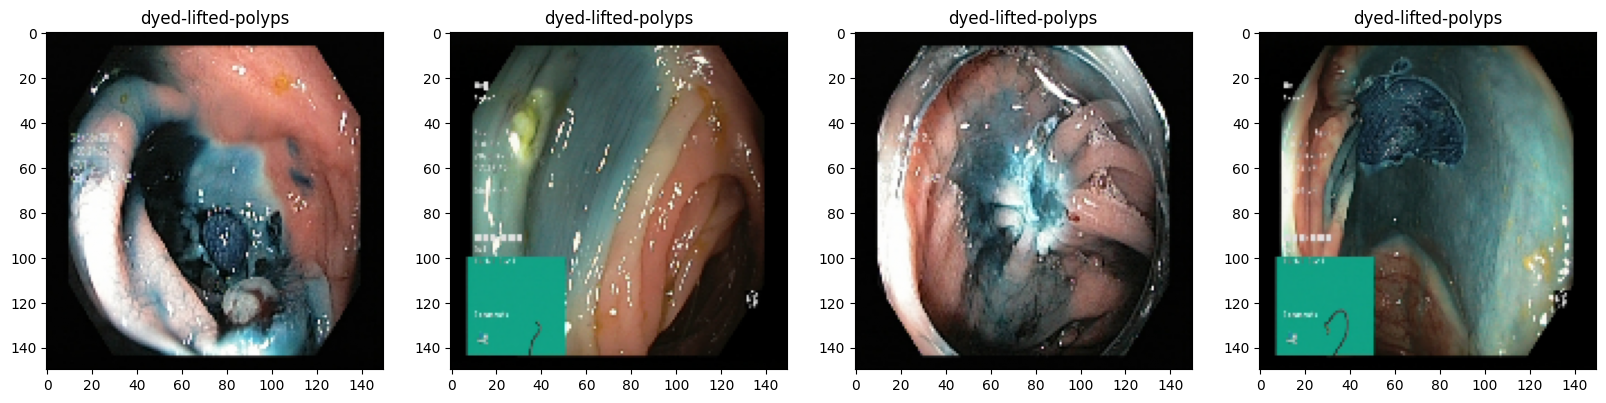

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('dyed-lifted-polyps')
    plt.imshow(x_dlp[i]/255)
    k=k+1

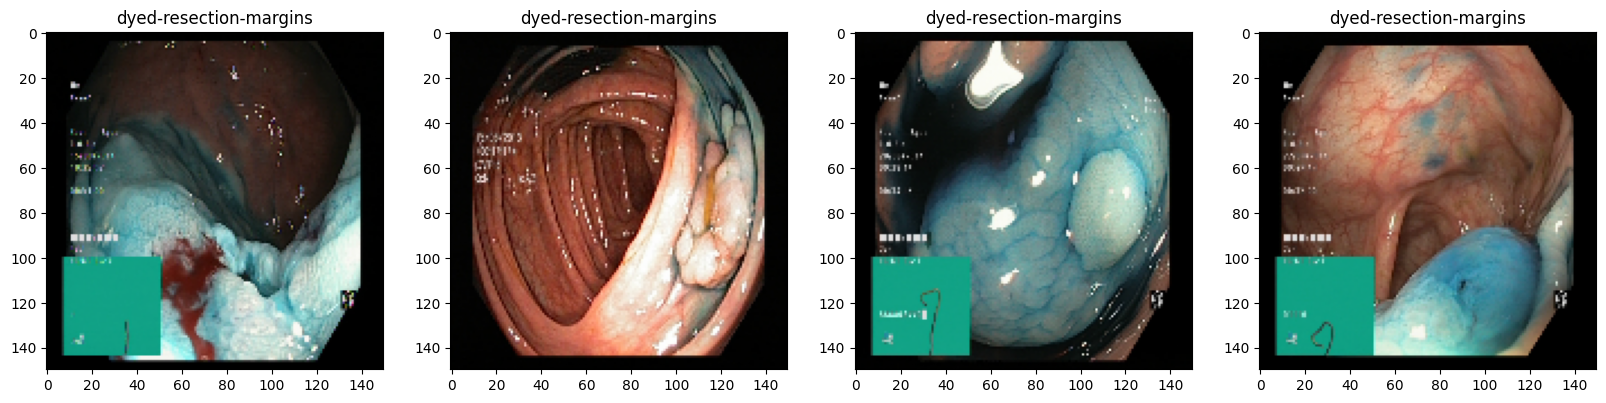

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('dyed-resection-margins')
    plt.imshow(x_dlm[i]/255)
    k=k+1

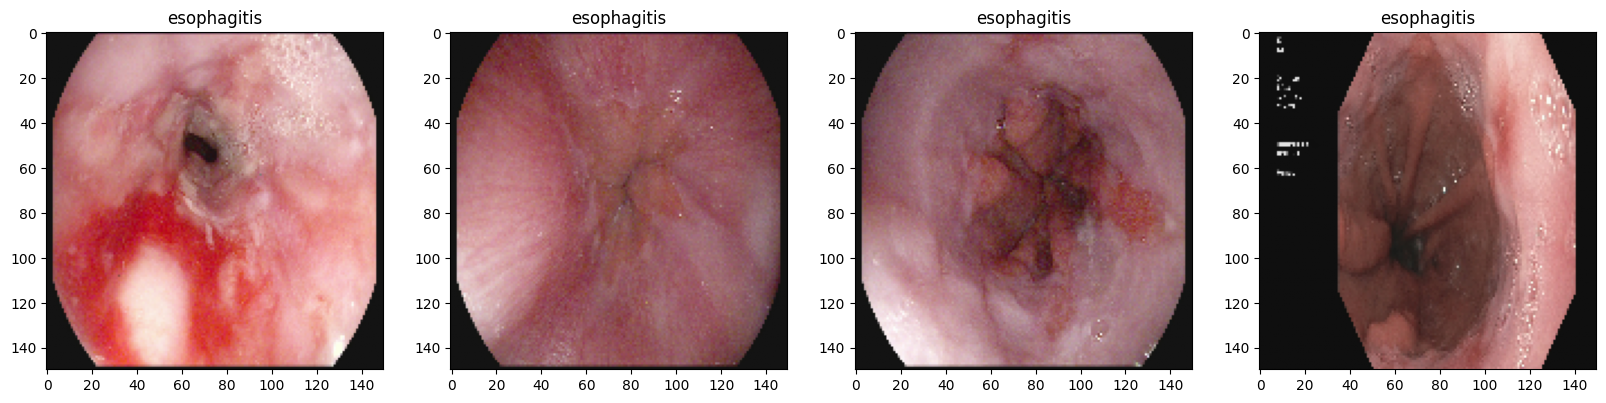

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('esophagitis')
    plt.imshow(x_e[i]/255)
    k=k+1

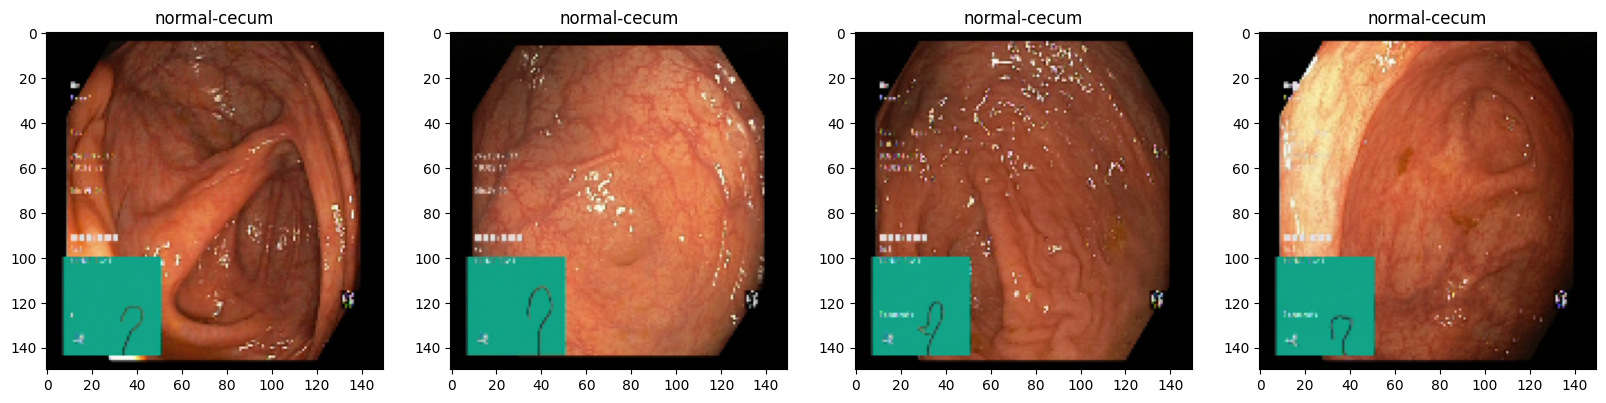

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('normal-cecum')
    plt.imshow(x_nc[i]/255)
    k=k+1

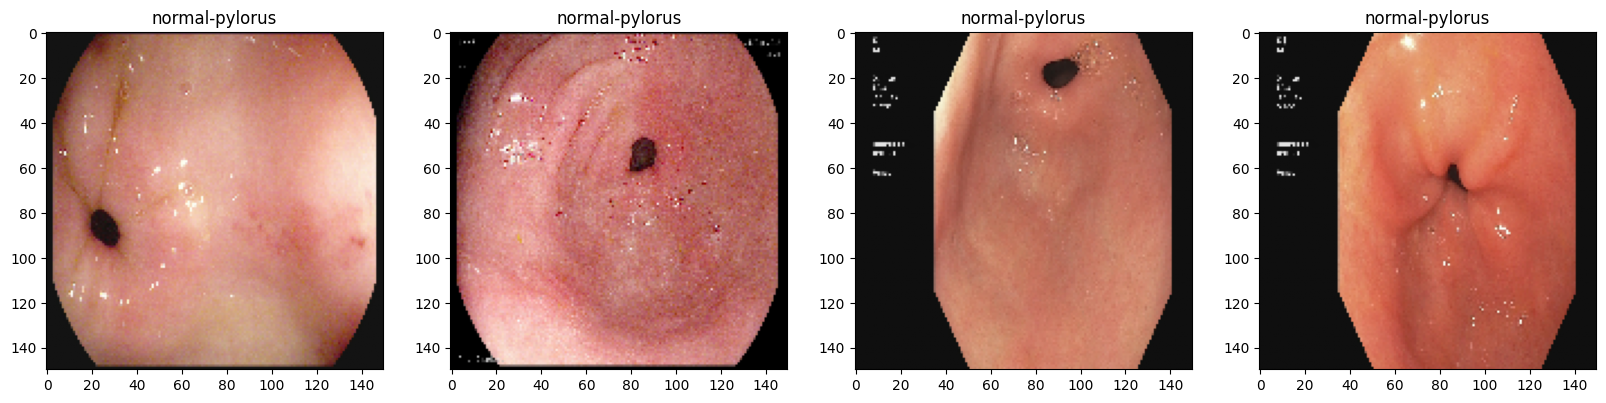

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('normal-pylorus')
    plt.imshow(x_np[i]/255)
    k=k+1

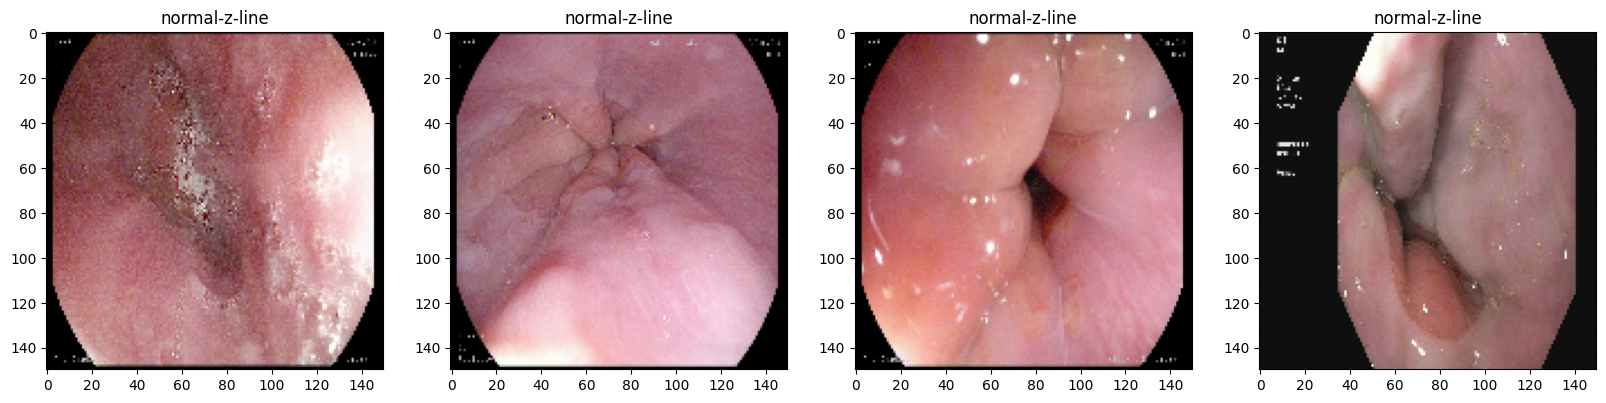

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('normal-z-line')
    plt.imshow(x_nz[i]/255)
    k=k+1

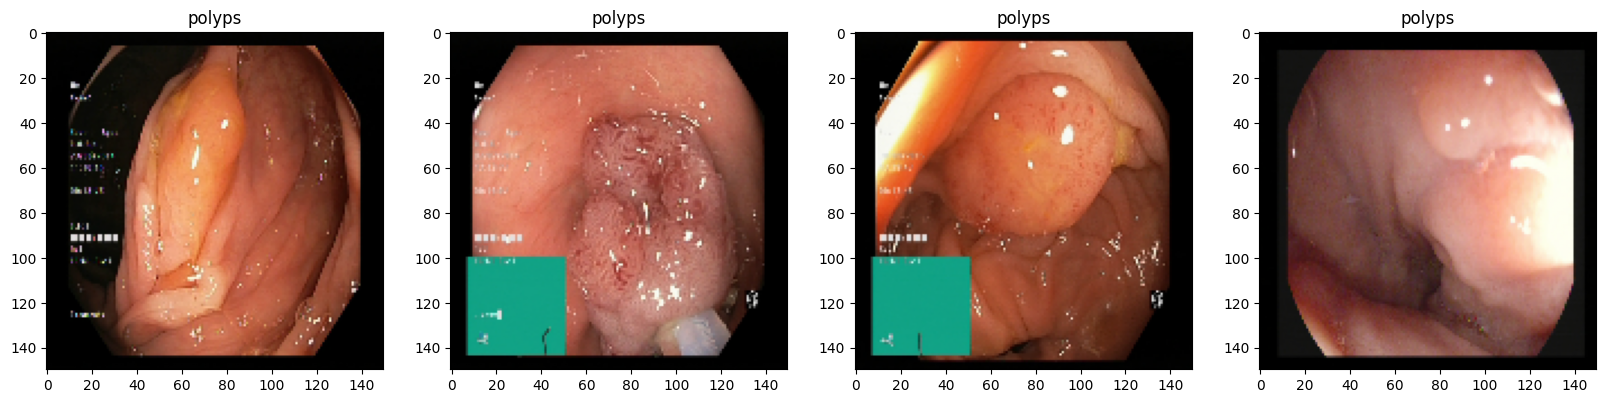

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('polyps')
    plt.imshow(x_p[i]/255)
    k=k+1

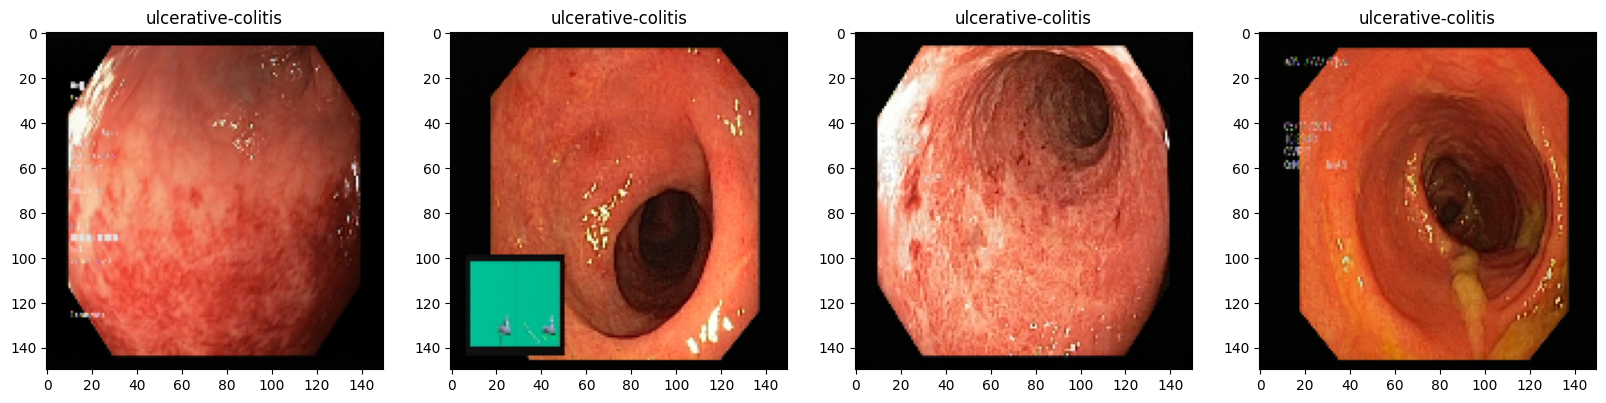

In [ ]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('ulcerative-colitis')
    plt.imshow(x_uc[i]/255)
    k=k+1

The purpose of reshaping the image data into a 4D tensor is to ensure that the input data has the correct shape for deep learning models to process. In particular, the 4D tensor has dimensions `(number of images, img_size, img_size, 3)`, where `number of images` is the number of images in the dataset, `img_size` is the size of the images after resizing, and `3` represents the number of color channels (1 for grayscale images, 3 for RGB images).

In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

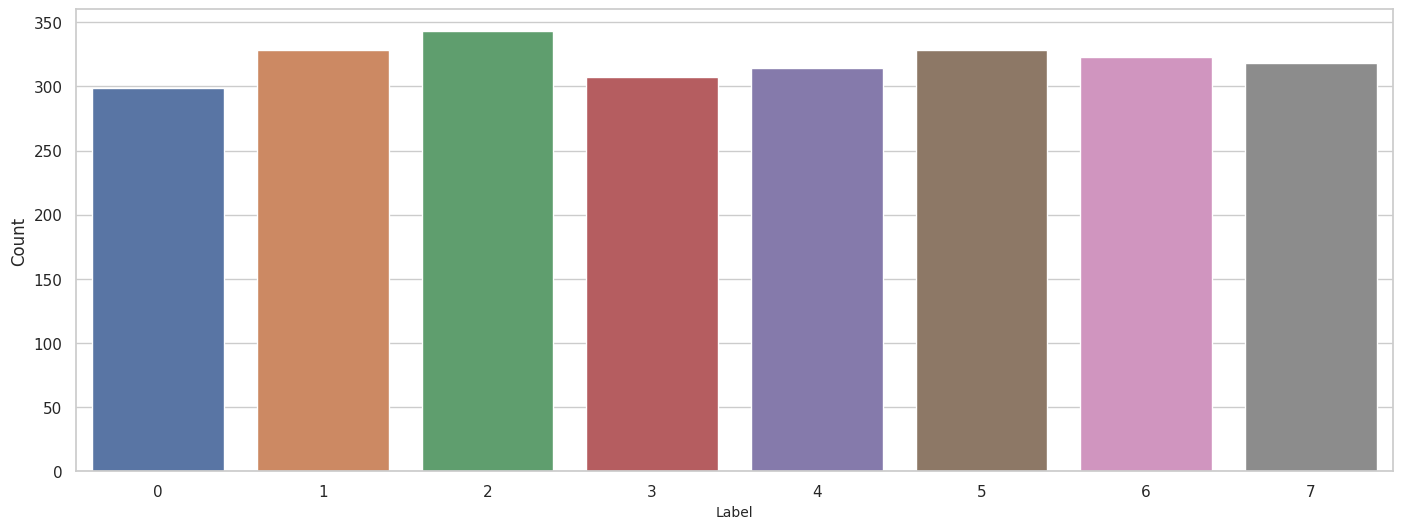

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(17, 6))
sns.countplot(x=y_train)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.show()

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

Training the model

In [ ]:
# Multiclass classification
model.add(Dense(8, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(x_val, y_val),callbacks=callbacks_list)

Epoch 1/100
80/80 [==============================] - 20s 239ms/step - loss: 1.0011 - accuracy: 0.6129 - val_loss: 0.6003 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - 19s 240ms/step - loss: 0.6057 - accuracy: 0.7621 - val_loss: 0.6245 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - 19s 234ms/step - loss: 0.5192 - accuracy: 0.7906 - val_loss: 0.5410 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - 19s 241ms/step - loss: 0.4738 - accuracy: 0.8113 - val_loss: 0.5351 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 5/100
80/80 [==============================] - 19s 243ms/step - loss: 0.4184 - accuracy: 0.8391 - val_loss: 0.5593 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 6/100
80/80 [==============================] - 18s 226ms/step - loss: 0.3959 - accuracy: 0.8387 - val_loss: 0.6418 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 7/100
80/80 [==============================] - 19s 2

<Axes: >

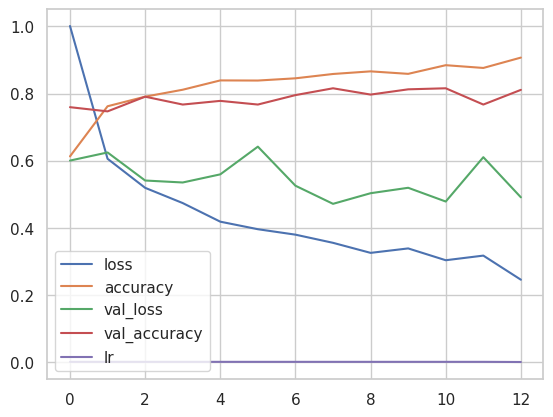

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

25/25 [==============================] - 2s 71ms/step - loss: 0.5067 - accuracy: 0.8037
Test Loss: 0.5066988468170166
Test Accuracy: 0.8037499785423279


Benchmark [Kaggle Notebook](https://www.kaggle.com/code/hitsh987/endoscopy-multiclassification?kernelSessionId=96140010):

Loss - 0.788
Accuracy - 0.863

# Brain MRI for Brain Tumor Detection

Importing Dataset

In [6]:
!mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Semester 7/BTP_new/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 93% 14.0M/15.1M [00:00<00:00, 14.9MB/s]
100% 15.1M/15.1M [00:00<00:00, 18.2MB/s]


In [8]:
!ls

brain-mri-images-for-brain-tumor-detection.zip	drive  sample_data


In [9]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

In [10]:
!rm brain-mri-images-for-brain-tumor-detection.zip
!ls

brain_tumor_dataset  drive  no	sample_data  yes


In [11]:
base_dir="/content/brain_tumor_dataset/"
yes_dir=base_dir+"yes/"
no_dir=base_dir+"no/"

yes = [yes_dir+"{}".format(i) for i in os.listdir(yes_dir) ]
no = [no_dir+"{}".format(i) for i in os.listdir(no_dir) ]

In [12]:
def get_imgs(path_arr,pneumonia,img_size=150):
  x=[]
  y=[]
  for img_loc in path_arr:
    try:
      img_arr = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
      img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
      resized_arr = cv2.resize(img_arr_rgb, (img_size, img_size)) # Reshaping images to preferred size
      x.append(resized_arr)
      y.append(pneumonia)
    except Exception as e:
      continue
  return((x,y))

In [13]:
x_yes,y_yes=get_imgs(yes,1,img_size)
x_no,y_no=get_imgs(no,0,img_size)
x=x_yes+x_no
y=y_yes+y_no
#get train test val
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

Pre-processing the data

In [14]:
#Normalize the data
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_val=np.array(x_val)/255

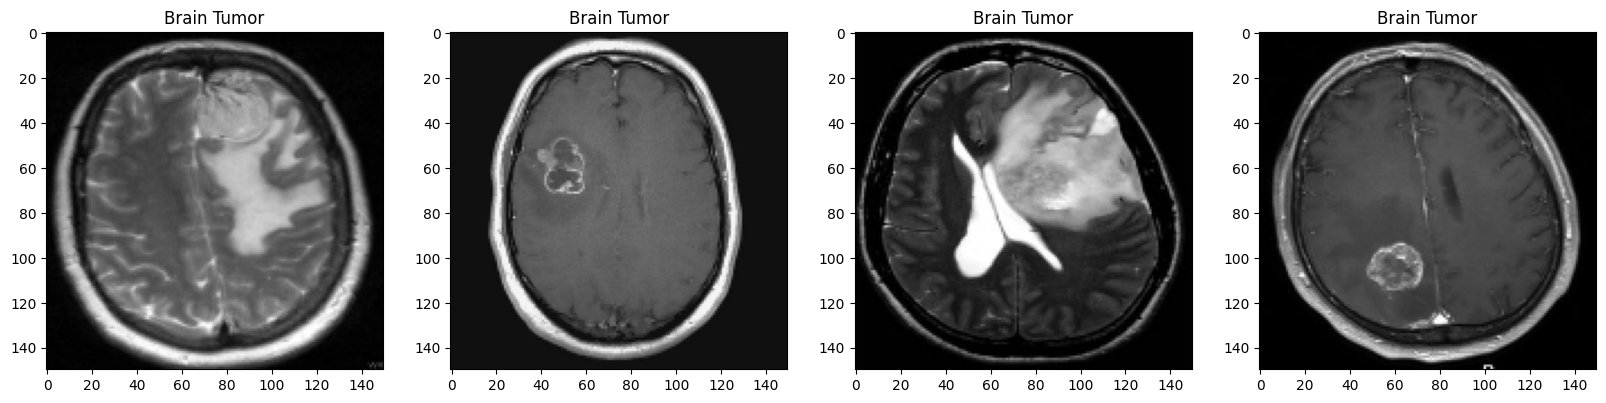

In [15]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('Brain Tumor')
    plt.imshow(x_yes[i]/255)
    k=k+1;

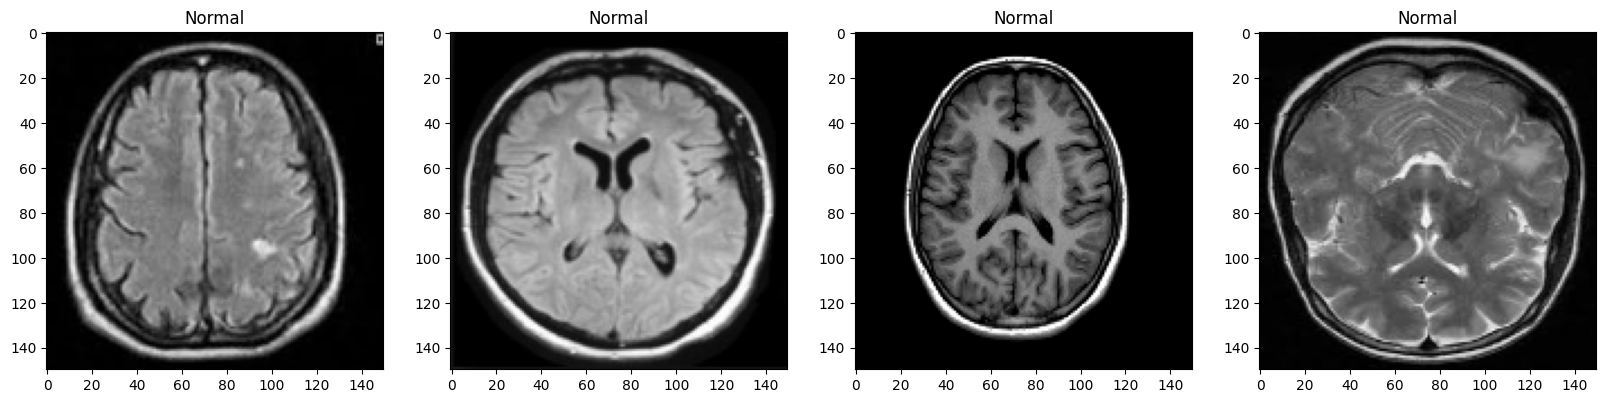

In [16]:
fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    a.set_title('Normal')
    plt.imshow(x_no[i]/255)
    k=k+1;

The purpose of reshaping the image data into a 4D tensor is to ensure that the input data has the correct shape for deep learning models to process. In particular, the 4D tensor has dimensions `(number of images, img_size, img_size, 3)`, where `number of images` is the number of images in the dataset, `img_size` is the size of the images after resizing, and `3` represents the number of color channels (1 for grayscale images, 3 for RGB images).

In [17]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

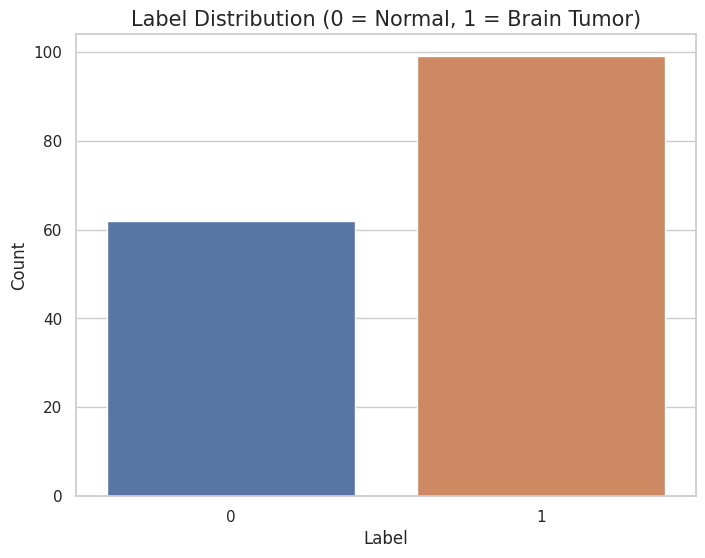

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Label Distribution (0 = Normal, 1 = Brain Tumor)", fontsize=15)
plt.show()

Training the model on Brain MRI to predict Brain Tumor

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
# Binary classification (1 or 0)
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

Epoch 1/100
6/6 [==============================] - 3s 337ms/step - loss: 0.7230 - accuracy: 0.5963 - val_loss: 0.6079 - val_accuracy: 0.7805 - lr: 1.0000e-04
Epoch 2/100
6/6 [==============================] - 2s 333ms/step - loss: 0.6707 - accuracy: 0.6211 - val_loss: 0.6219 - val_accuracy: 0.6341 - lr: 1.0000e-04
Epoch 3/100
6/6 [==============================] - 1s 199ms/step - loss: 0.5981 - accuracy: 0.6894 - val_loss: 0.5157 - val_accuracy: 0.8049 - lr: 1.0000e-04
Epoch 4/100
6/6 [==============================] - 1s 208ms/step - loss: 0.5769 - accuracy: 0.6894 - val_loss: 0.4868 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 5/100
6/6 [==============================] - 1s 162ms/step - loss: 0.5732 - accuracy: 0.7205 - val_loss: 0.4600 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 6/100
6/6 [==============================] - 1s 163ms/step - loss: 0.5697 - accuracy: 0.7391 - val_loss: 0.4420 - val_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 7/100
6/6 [==============================] - 1

<Axes: >

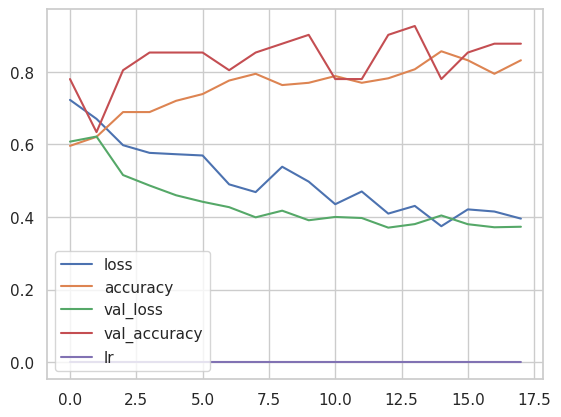

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2/2 [==============================] - 0s 85ms/step - loss: 0.3457 - accuracy: 0.9216
Test Loss: 0.3456864356994629
Test Accuracy: 0.9215686321258545


Benchmark [Kaggle Notebook](https://www.kaggle.com/code/ashisharya01/brain-tumour-detection-99-train-acc-92-test-acc?kernelSessionId=460569150):

Loss - 0.22567613422870636
Accuracy - 0.9223300814628601